In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import shutil
from tqdm import tqdm

In [92]:
# Setting random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Declaring Parameters
IMG_SIZE = 224 
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 0.0001
ORIGINAL_DATA_DIR = "C:\\Users\\suraj\\AI and Application CA\\brain_tumor_dataset"
TRAIN_SPLIT = 0.65 # 65% for training
TEST_SPLIT = 0.15   # 20% for testing
VAL_SPLIT = 0.20    # 15% for validation
TARGET_SAMPLES_PER_CLASS = 150  # Target number of samples after augmentation for each class.

In [94]:
def load_dataset(data_dir, img_size=(224, 224), preprocess=True):
    """
    Load and preprocess image dataset from provided directory.
    
    This function expects a directory structure where images are organized in subdirectories
    by class ('yes' and 'no' folders). It loads all images, converts them to arrays,
    and applies preprocessing if required.
    
    Args:
        data_dir: Root directory containing class subdirectories
        img_size: Tuple specifying target image dimensions (width, height)
        preprocess: Whether to apply model-specific preprocessing
        
    Returns:
        X: Numpy array of preprocessed images
        y: Numpy array of labels (1 for positive/yes, 0 for negative/no)
        filenames: List of original filenames for reference
    """
    print(f"Loading dataset from {data_dir}...")
    X = []
    y = []
    filenames = []

    extensions = ['.jpg', '.jpeg', '.png'] #The provided dataset had files for all three of these formats.
    
    # Process directories for each class
    for class_name, label in [('yes', 1), ('no', 0)]: 
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Directory {class_path} not found")
            continue
            
        # Gather all image files with various extensions
        image_files = []
        for ext in extensions:
            image_files.extend(glob.glob(os.path.join(class_path, f"*{ext}")))
        
        print(f"Found {len(image_files)} {class_name} examples")
        
        # Process each image file
        for img_path in image_files:
            try:
                # Load and resize image to the target dimensions, with RGB model to comply with my model architecture's requirements
                img = load_img(img_path, target_size=img_size, color_mode='rgb')
                # Convert images to array
                img_array = img_to_array(img)
                X.append(img_array)
                y.append(label)
                filenames.append(os.path.basename(img_path))
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    # Convert lists to numpy arrays for efficiency
    X = np.array(X)
    y = np.array(y)
    
    # Apply preprocessing, always TRUE by default - applied to comply with my model architecture's requirements
    if preprocess:
        print("Applying model preprocessing...")
        X = preprocess_input(X)
    
    # Report dataset statistics
    print(f"Dataset loaded: {len(X)} images, {sum(y)} positive, {len(X) - sum(y)} negative")
    return X, y, filenames

In [96]:
# Helps with the imbalanced dataset.
def compute_class_weights(y):
    #uses compute_class_weight() function from sklearn.utils class_weights to calculate balanced class weights.
    class_weights = class_weight.compute_class_weight( 
        class_weight='balanced',
        classes=np.unique(y),
        y=y
    )
    return dict(enumerate(class_weights))

In [ ]:
# Data generators for augmentation
def create_data_generators(X_train, X_val, y_train, y_val, target_samples=300):
    """
    Create data generators with augmentation to address class imbalance.
    
    This function implements a two-pronged approach to handle imbalanced data:
    1. Data augmentation to generate additional samples for minority classes
    2. Targets a balanced class distribution by generating synthetic samples
    
    Args:
        X_train: Training features (images)
        X_val: Validation features (images)
        y_train: Training labels
        y_val: Validation labels
        target_samples: Target number of samples per class after augmentation
        
    Returns:
        train_generator: Generator for augmented training data
        validation_generator: Generator for validation data
        X_aug: Augmented training features array
        y_aug: Augmented training labels array
    """
     # Counts samples in each class to determine imbalance
    class_counts = np.bincount(y_train)
    print(f"Original training set class distribution: {class_counts}")

    # Configure augmentation parameters for training data
    # These transformations create variations of existing images
    train_datagen = ImageDataGenerator(
        rotation_range=10, # Rotate images by up to 10 degrees
        width_shift_range=0.1, # Shift images horizontally by up to 10%
        height_shift_range=0.1, # Shift images vertically by up to 10%
        shear_range=0.1, # Apply shearing transformations
        brightness_range=(0.3, 1.0), # Randomly adjust brightness
        horizontal_flip=True, # Flip images horizontally
        vertical_flip=False, # Don't flip images vertically (often not suitable for medical images)
        fill_mode='nearest' # Fill in newly created pixels with nearest pixel values
        )

    # No augmentation for validation set to evaluate on clean data
    val_datagen = ImageDataGenerator()
    
    # Create a generator that will keep creating augmented samples
    aug_gen = train_datagen.flow(
        X_train, 
        y_train,
        batch_size=32,
        shuffle=True
    )
    
    # Create augmented dataset to reach target_samples per class
    X_aug = []
    y_aug = []
    
    # Add original samples first
    X_aug.extend(X_train)
    y_aug.extend(y_train)
    
    # Generate additional samples for each class to reach target for both the classes
    for class_label in [0, 1]:
        samples_needed = target_samples - np.sum(y_train == class_label)
        # Skip augmentation if this class already has enough samples
        if samples_needed <= 0:
            print(f"Class {class_label} already has {np.sum(y_train == class_label)} samples, no augmentation needed")
            continue
            
        print(f"Generating {samples_needed} augmented samples for class {class_label}")
        
        # Get indices of samples from this class
        class_indices = np.where(y_train == class_label)[0]
        
        # Generate augmented samples
        batches_generated = 0
        with tqdm(total=samples_needed) as pbar:
            while batches_generated < samples_needed:
                # Randomly select a sample from the current class
                idx = np.random.choice(class_indices)
                X_sample = X_train[idx:idx+1]
                y_sample = y_train[idx:idx+1]
                
                # Generate an augmented version of the selected sample
                X_batch, y_batch = next(train_datagen.flow(X_sample, y_sample, batch_size=1))
                
                # Add the augmented sample to our dataset
                X_aug.append(X_batch[0])
                y_aug.append(y_batch[0])
                
                batches_generated += 1
                pbar.update(1)
    
    # Convert lists to numpy arrays for efficient processing
    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    
    # Print augmented dataset statistics
    aug_class_counts = np.bincount(y_aug.astype(int))
    print(f"Augmented training set: {len(X_aug)} samples")
    print(f"Augmented class distribution: Class 0: {aug_class_counts[0]}, Class 1: {aug_class_counts[1]}")
    
    # Create generator from the augmented data for training
    train_generator = train_datagen.flow(
        X_aug,
        y_aug,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    # Create validation generator (no augmentation needed for validation)
    validation_generator = val_datagen.flow(
        X_val,
        y_val,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    return train_generator, validation_generator, X_aug, y_aug

In [ ]:
# Build the model with transfer learning and partial unfreezing
def build_model():
    """
    Builds and returns a transfer learning model based on EfficientNetB0.
    
    This function creates a model using EfficientNetB0 as the base, with custom
    classification layers on top. It implements partial unfreezing of layers to 
    enable fine-tuning while preserving lower-level features from pre-training.
    
    Returns:
        model: Compiled Keras Sequential model ready for training
        base_model: Reference to the base EfficientNetB0 model
    """

    # Load pre-trained EfficientNetB0 with no top layer
    # We use weights pre-trained on ImageNet and specify our input shape
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Fine-tuning approach: Freeze early layers but allow the last 8 layers to be trainable
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    
    # Create the model architecture using Sequential API
    model = tf.keras.models.Sequential([
        # Base model for feature extraction
        base_model,
        # Global pooling reduces spatial dimensions while preserving feature channels
        tf.keras.layers.GlobalAveragePooling2D(),
        # Batch normalization normalizes activations, improving training stability
        tf.keras.layers.BatchNormalization(),
        # Dense hidden layer with ReLU activation for non-linearity
        tf.keras.layers.Dense(128, activation='relu'), 
        # # Dropout for regularization (high rate of 0.6 to combat overfitting)
        tf.keras.layers.Dropout(0.6),
        # Additional batch normalization before final classification
        tf.keras.layers.BatchNormalization(),
        # Output layer with sigmoid activation for binary classification
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    # Compile the model with optimizer, loss function, and evaluation metrics
    model.compile(
        # Adam optimizer with specified learning rate
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        # Binary cross-entropy is standard for binary classification
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model, base_model

In [102]:
# Set up callbacks
def create_callbacks():
    """
    Creates a list of callbacks for model training.
    
    This function sets up three common callbacks that help with training optimization:
    1. Early stopping to prevent overfitting by monitoring validation loss
    2. Model checkpoint to save the best model based on validation accuracy
    3. Learning rate reduction to adjust learning rate when progress plateaus
    
    Returns:
        List of Keras callback objects
    """
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss', # Monitor validation loss
        patience=4, # Number of epochs with no improvement after which training will stop
        restore_best_weights=True, # Restore model weights from the epoch with the best validation loss
        verbose=1 # Report when early stopping is triggered
    )

    # Model checkpoint to save the best model
    checkpoint = ModelCheckpoint(
        'best_model.h5', # Filepath to save the model
        monitor='val_accuracy', # Monitor validation accuracy
        save_best_only=True, # Only save when the monitored quantity improves
        verbose=1 # Report when checkpoint is saved
    )

    # Reduce learning rate when a metric has stopped improving
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', # Monitor validation loss
        factor=0.2, # Factor by which the learning rate will be reduced
        patience=4, # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-7, # Lower bound on the learning rate
        verbose=1 # Report when learning rate is reduced
    )

    return [early_stopping, checkpoint, reduce_lr]

In [104]:
# Train the model
def train_model(model, train_generator, validation_generator, callbacks, class_weights=None):
    """
    Trains the model using data generators and specified callbacks.
    
    This function handles the training process including:
    - Setting appropriate steps per epoch based on generator length
    - Applying class weights for imbalanced datasets
    - Running the training loop with validation
    
    Args:
        model: The compiled Keras model to train
        train_generator: Generator for training data
        validation_generator: Generator for validation data
        callbacks: List of callbacks for the training process
        class_weights: Optional dictionary mapping class indices to weights
    
    Returns:
        history: Training history object containing metrics for each epoch
    """

    # Calculate steps per epoch for both training and validation
    # This ensures we go through the entire dataset each epoch
    steps_per_epoch = len(train_generator)
    validation_steps = len(validation_generator)

     # Train the model with the specified parameters
    history = model.fit(
        train_generator, # Generator for training data batches
        steps_per_epoch=steps_per_epoch,  # Number of batch iterations before an epoch is finished
        epochs=EPOCHS, # Total number of epochs to train
        validation_data=validation_generator, # Generator for validation data
        validation_steps=validation_steps, # Number of validation steps per epoch
        callbacks=callbacks, # List of callbacks to apply during training
        class_weight=class_weights,  # Weights to apply to classes (important for imbalanced datasets)
        verbose=1 # Show progress bar and metrics during training
    )

    return history

In [106]:
def visualize_predictions(X_test, y_test, y_pred, num_images=5, batch_size=32, save_path='prediction_examples.png'):
    """
    Visualize model predictions with efficient batch processing.
    
    Parameters:
    -----------
    X_test : numpy.ndarray
        Test images preprocessed for the model
    y_test : numpy.ndarray
        Ground truth labels
    y_pred : numpy.ndarray
        Predicted labels
    num_images : int
        Number of images to visualize
    batch_size : int
        Size of batches for processing
    save_path : str
        Path to save the visualization
    """  
    # Limit to the requested number of images
    num_to_display = min(num_images, len(X_test))
    X_display = X_test[:num_to_display].copy()
    y_test_display = y_test[:num_to_display]
    y_pred_display = y_pred[:num_to_display]
    
    # Process images in batches to reduce memory usage
    for i in range(0, len(X_display), batch_size):
        batch_end = min(i + batch_size, len(X_display))
        batch = X_display[i:batch_end]

        # Reverse EfficientNet preprocessing
        batch = (batch + 1) / 2.0  # Convert from [-1, 1] to [0, 1]
        batch = np.clip(batch, 0, 1)
        
        X_display[i:batch_end] = batch
    
    # Create a figure with the appropriate size
    fig, axes = plt.subplots(1, num_to_display, figsize=(3*num_to_display, 4))
    
    # Handle the case when num_to_display is 1
    if num_to_display == 1:
        axes = [axes]
    
    # Plot each image with its labels
    for i, ax in enumerate(axes):
        ax.imshow(X_display[i])
        
        true_label = 'Tumor' if y_test_display[i] == 1 else 'No Tumor'
        pred_label = 'Tumor' if y_pred_display[i] == 1 else 'No Tumor'
        
        color = 'green' if true_label == pred_label else 'red'
        
        ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=color)
        ax.axis('off')
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print metrics for this sample
    correct = sum(y_test_display == y_pred_display)
    print(f"Sample accuracy: {correct}/{num_to_display} = {correct/num_to_display:.2f}")

In [108]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model on test data and calculates various performance metrics.
    
    This function:
    1. Generates probability predictions
    2. Converts probabilities to binary predictions using a threshold of 0.5
    3. Calculates confusion matrix, classification report, and ROC curve metrics
    
    Args:
        model: Trained Keras model
        X_test: Test features/images
        y_test: True test labels
        
    Returns:
        y_pred: Binary predictions (0 or 1)
        y_pred_prob: Probability predictions (0.0 to 1.0)
        cm: Confusion matrix
        report: Classification report string
        fpr: False positive rates for ROC curve
        tpr: True positive rates for ROC curve
        roc_auc: Area under ROC curve
    """
    # Get probability predictions from the model
    y_pred_prob = model.predict(X_test)
    y_pred_prob = y_pred_prob.flatten()

    # Convert probabilities to binary predictions using 0.5 threshold
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate standard classification metrics
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor'])

    # Calculate ROC curve and AUC 
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob) # Get points for ROC curve
    roc_auc = auc(fpr, tpr) # Calculate area under the ROC curve

    return y_pred, y_pred_prob, cm, report, fpr, tpr, roc_auc

In [ ]:
def plot_prediction_comparison(y_true, y_pred_prob, save_path='prediction_comparison.png'):
    """
    Creates a scatter plot comparing true labels with predicted probabilities.
    
    Args:
        y_true: True labels
        y_pred_prob: Predicted probabilities
        save_path: Path to save the visualization
    """
    # Convert probabilities to binary predictions using threshold 0.5
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    
    # Calculate accuracy for reference
    accuracy = accuracy_score(y_true, y_pred)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot true labels and predicted probabilities
    plt.plot(np.arange(len(y_true)), y_true, 
             label='True Labels (0=No Tumor, 1=Tumor)', 
             color='blue', marker='o', linestyle='None', alpha=0.7)
    
    plt.plot(np.arange(len(y_pred_prob)), y_pred_prob, 
             label='Predicted Probabilities', 
             color='red', marker='x', linestyle='None')
    
    # Add a threshold line at 0.5
    plt.axhline(y=0.5, color='green', linestyle='--', alpha=0.7, 
                label='Decision Threshold (0.5)')
    
    # Add labels and title
    plt.xlabel('Sample Index')
    plt.ylabel('Class Label / Probability')
    plt.title(f'True Labels vs. Predicted Probabilities (Accuracy: {accuracy:.4f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Ensure y-axis shows a bit beyond 0 and 1 for clarity
    plt.ylim(-0.1, 1.1)
    
    # Save the figure
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    return accuracy

In [112]:
def plot_training_history(history):
    """
    Visualizes the training metrics over epochs.
    
    Creates a figure with three subplots showing:
    1. Training and validation accuracy
    2. Training and validation loss
    3. Training and validation AUC
    
    Args:
        history: Keras History object containing training metrics
    """
    # Check which metrics are available in the history
    print("Available metrics:", history.history.keys())

    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Accuracy plot
    axs[0].plot(history.history['accuracy'], label='Training Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Loss plot
    axs[1].plot(history.history['loss'], label='Training Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    # Plot AUC metrics (finds AUC key dynamically in case the name varies)
    auc_key = [k for k in history.history.keys() if 'auc' in k.lower()]
    if auc_key:
        auc_key = auc_key[0]
        val_auc_key = 'val_' + auc_key
        axs[2].plot(history.history[auc_key], label='Training AUC')
        axs[2].plot(history.history[val_auc_key], label='Validation AUC')
        axs[2].set_title('AUC')
        axs[2].set_xlabel('Epoch')
        axs[2].set_ylabel('AUC')
        axs[2].legend()
    # Ensure subplots are properly spaced
    plt.tight_layout()
    # Save the figure as an image file
    plt.savefig('training_history.png')
    # Display the figure
    plt.show()

Loading dataset from C:\Users\suraj\AI and Application CA\brain_tumor_dataset...
Found 150 yes examples
Found 73 no examples
Applying model preprocessing...
Dataset loaded: 223 images, 150 positive, 73 negative

Data split statistics:
Total dataset: 223 samples
Train set: 144 samples (64.6%), Class distribution: [47 97]
Validation set: 45 samples (20.2%), Class distribution: [15 30]
Test set: 34 samples (15.2%), Class distribution: [11 23]
Original training set class distribution: [47 97]
Generating 103 augmented samples for class 0


100%|██████████| 103/103 [00:01<00:00, 99.90it/s]


Generating 53 augmented samples for class 1


100%|██████████| 53/53 [00:00<00:00, 98.33it/s] 


Augmented training set: 300 samples
Augmented class distribution: Class 0: 150, Class 1: 150
Class weights: {0: 1.0, 1: 1.0}

Building the model...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,219,300 (16.10 MB)

 Trainable params: 1,060,145 (4.04 MB)

 Non-trainable params: 3,159,155 (12.05 MB)


Training the model...


C:\Users\suraj\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.5131 - auc_4: 0.5246 - loss: 0.8526 - precision_4: 0.5263 - recall_4: 0.5042
Epoch 1: val_accuracy improved from -inf to 0.68889, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 515ms/step - accuracy: 0.5120 - auc_4: 0.5239 - loss: 0.8530 - precision_4: 0.5245 - recall_4: 0.5033 - val_accuracy: 0.6889 - val_auc_4: 0.6700 - val_loss: 0.6244 - val_precision_4: 0.7000 - val_recall_4: 0.9333 - learning_rate: 1.0000e-04
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.5945 - auc_4: 0.6248 - loss: 0.7317 - precision_4: 0.6293 - recall_4: 0.5982
Epoch 2: val_accuracy improved from 0.68889 to 0.73333, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step - accuracy: 0.5971 - auc_4: 0.6273 - loss: 0.7296 - precision_4: 0.6301 - recall_4: 0.6009 - val_accuracy: 0.7333 - val_auc_4: 0.8100 - val_loss: 0.5959 - val_precision_4: 0.7647 - val_recall_4: 0.8667 - learning_rate: 1.0000e-04
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6605 - auc_4: 0.7406 - loss: 0.6083 - precision_4: 0.6256 - recall_4: 0.6679
Epoch 3: val_accuracy improved from 0.73333 to 0.82222, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - accuracy: 0.6612 - auc_4: 0.7411 - loss: 0.6081 - precision_4: 0.6278 - recall_4: 0.6688 - val_accuracy: 0.8222 - val_auc_4: 0.8422 - val_loss: 0.5736 - val_precision_4: 0.8438 - val_recall_4: 0.9000 - learning_rate: 1.0000e-04
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.7275 - auc_4: 0.7968 - loss: 0.5608 - precision_4: 0.7928 - recall_4: 0.6726
Epoch 4: val_accuracy did not improve from 0.82222
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 318ms/step - accuracy: 0.7284 - auc_4: 0.7974 - loss: 0.5599 - precision_4: 0.7910 - recall_4: 0.6753 - val_accuracy: 0.8222 - val_auc_4: 0.8622 - val_loss: 0.5479 - val_precision_4: 0.8438 - val_recall_4: 0.9000 - learning_rate: 1.0000e-04
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.7187 - auc_4: 0.7828 - loss: 0.5794 - precision_4: 0.7037 - recall_4: 0.7346
Epoch 5: val_accuracy improved from 0.82222 to 0.84444, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.7186 - auc_4: 0.7833 - loss: 0.5792 - precision_4: 0.7047 - recall_4: 0.7329 - val_accuracy: 0.8444 - val_auc_4: 0.8733 - val_loss: 0.5212 - val_precision_4: 0.8710 - val_recall_4: 0.9000 - learning_rate: 1.0000e-04
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7879 - auc_4: 0.8524 - loss: 0.4793 - precision_4: 0.7868 - recall_4: 0.7721
Epoch 6: val_accuracy did not improve from 0.84444
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - accuracy: 0.7875 - auc_4: 0.8518 - loss: 0.4803 - precision_4: 0.7873 - recall_4: 0.7711 - val_accuracy: 0.8222 - val_auc_4: 0.8644 - val_loss: 0.4927 - val_precision_4: 0.8438 - val_recall_4: 0.9000 - learning_rate: 1.0000e-04
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8225 - auc_4: 0.8923 - loss: 0.4275 - precision_4: 0.8657 - recall_4: 0.7836
Epoch 7: val_accuracy did not improve from 0.84444
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 344ms/step - accuracy: 0.8211 - auc_4: 0

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - accuracy: 0.8045 - auc_4: 0.9052 - loss: 0.3863 - precision_4: 0.8101 - recall_4: 0.8142 - val_accuracy: 0.8667 - val_auc_4: 0.8978 - val_loss: 0.3673 - val_precision_4: 0.8529 - val_recall_4: 0.9667 - learning_rate: 1.0000e-04
Epoch 14/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8601 - auc_4: 0.9472 - loss: 0.3020 - precision_4: 0.8672 - recall_4: 0.8544
Epoch 14: val_accuracy did not improve from 0.86667
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - accuracy: 0.8609 - auc_4: 0.9475 - loss: 0.3012 - precision_4: 0.8678 - recall_4: 0.8554 - val_accuracy: 0.8667 - val_auc_4: 0.8978 - val_loss: 0.3662 - val_precision_4: 0.8529 - val_recall_4: 0.9667 - learning_rate: 1.0000e-04
Epoch 15/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8414 - auc_4: 0.9203 - loss: 0.3535 - precision_4: 0.8415 - recall_4: 0.8377
Epoch 15: val_accuracy did not improve from 0.86667
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 324ms/step - accuracy: 0.8425 - auc_

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8658 - auc_4: 0.9331 - loss: 0.3500 - precision_4: 0.8423 - recall_4: 0.8874 - val_accuracy: 0.8889 - val_auc_4: 0.9044 - val_loss: 0.3624 - val_precision_4: 0.8571 - val_recall_4: 1.0000 - learning_rate: 1.0000e-04
Epoch 19/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9061 - auc_4: 0.9487 - loss: 0.2968 - precision_4: 0.8976 - recall_4: 0.9153
Epoch 19: val_accuracy did not improve from 0.88889
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - accuracy: 0.9055 - auc_4: 0.9484 - loss: 0.2976 - precision_4: 0.8974 - recall_4: 0.9142 - val_accuracy: 0.8889 - val_auc_4: 0.9078 - val_loss: 0.3650 - val_precision_4: 0.8571 - val_recall_4: 1.0000 - learning_rate: 1.0000e-04
Epoch 20/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8570 - auc_4: 0.9491 - loss: 0.3129 - precision_4: 0.8995 - recall_4: 0.8369
Epoch 20: val_accuracy did not improve from 0.88889
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.8565 - auc_

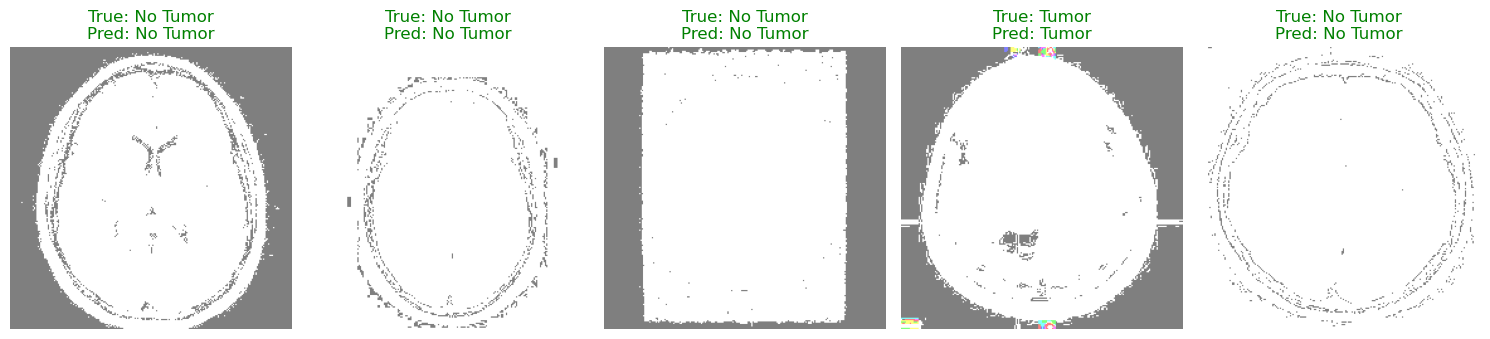

Sample accuracy: 5/5 = 1.00

Test Set Evaluation Results:
AUC: 0.9842

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.83      0.91      0.87        11
       Tumor       0.95      0.91      0.93        23

    accuracy                           0.91        34
   macro avg       0.89      0.91      0.90        34
weighted avg       0.92      0.91      0.91        34


Confusion Matrix:
[[10  1]
 [ 2 21]]


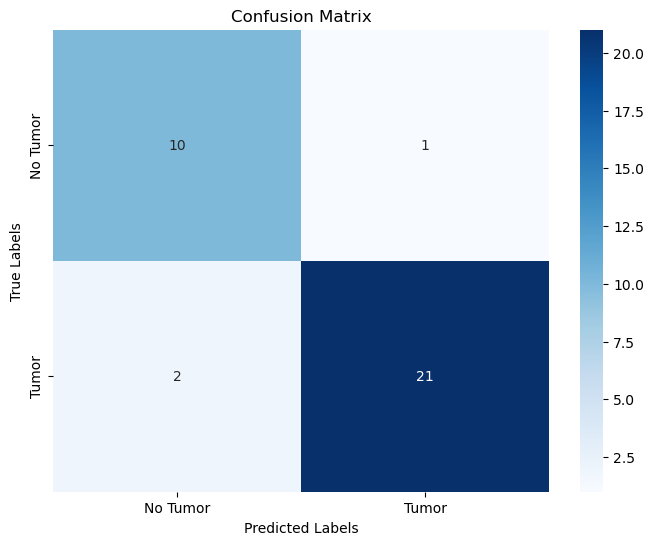

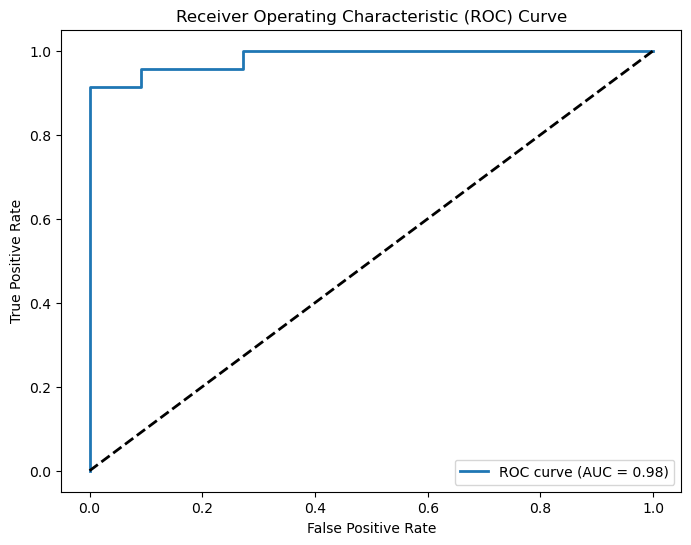

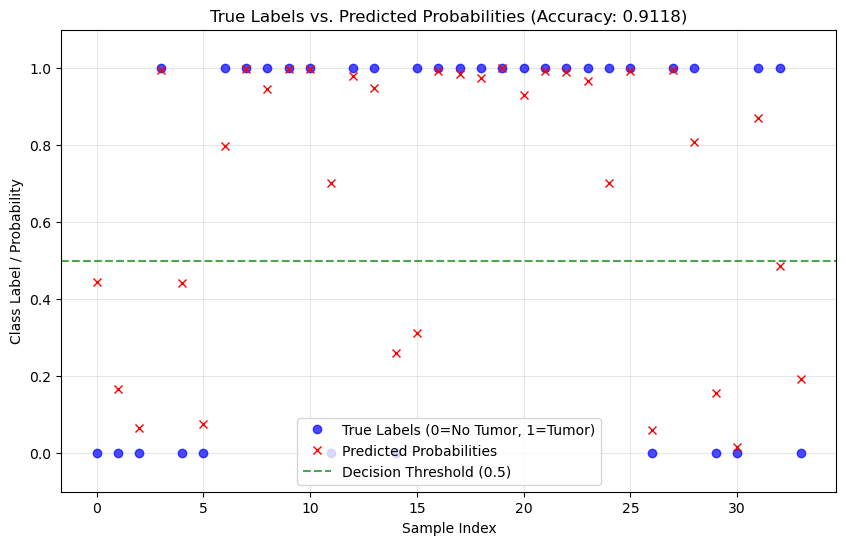

Available metrics: dict_keys(['accuracy', 'auc_4', 'loss', 'precision_4', 'recall_4', 'val_accuracy', 'val_auc_4', 'val_loss', 'val_precision_4', 'val_recall_4', 'learning_rate'])


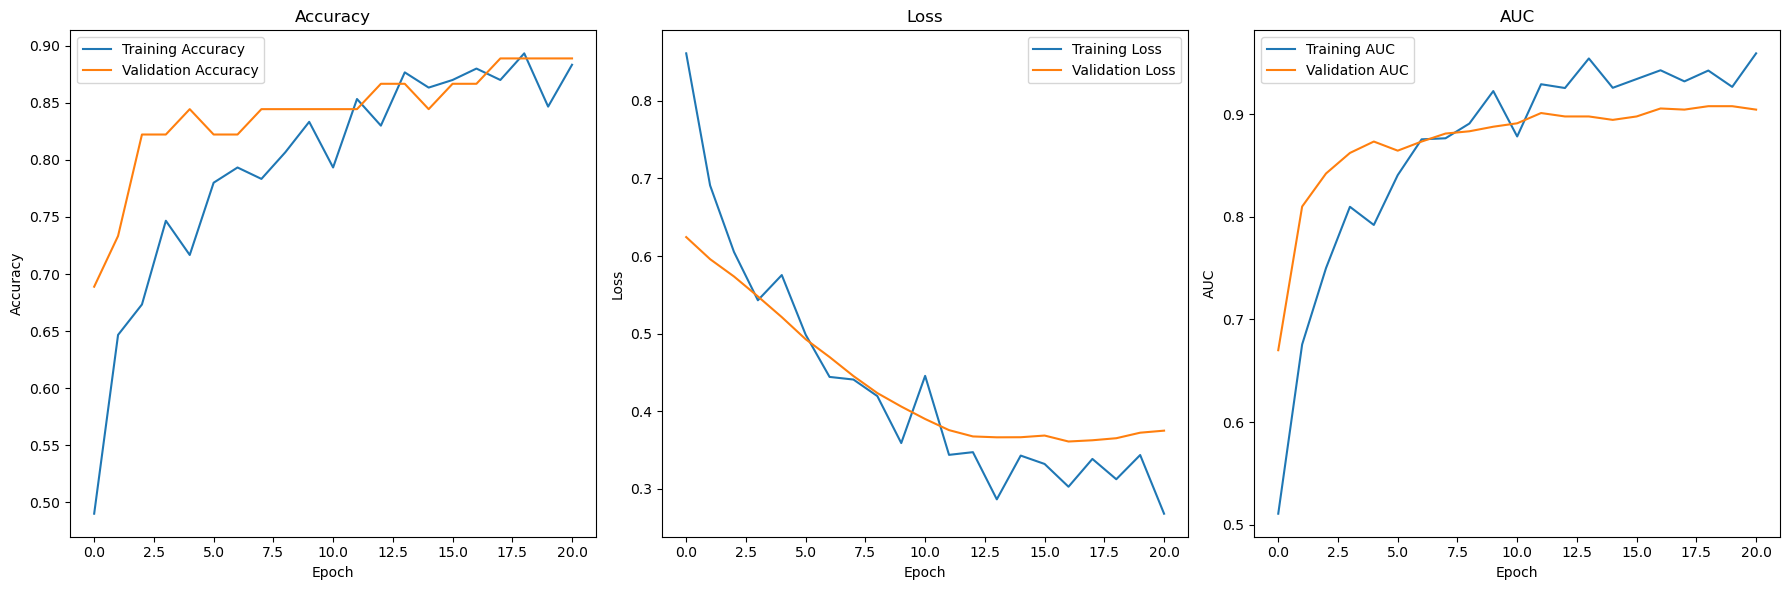

Model saved as 'brain_tumor_model_final.h5'
Evaluation results saved to 'evaluation_results.csv'


In [114]:
def main():
    """
    Main function that orchestrates the entire machine learning pipeline:
    1. Data loading and splitting
    2. Data augmentation and preparation
    3. Model building and training
    4. Model evaluation and visualization
    5. Saving results and the trained model
    """
    # Load the complete dataset (with default values for other arguments)
    X, y, filenames = load_dataset(ORIGINAL_DATA_DIR)
    
    # First split: separate test set (15%)
    # Calculate adjusted test split ratio to get the correct final proportions
    adjusted_test_split = TEST_SPLIT / (TEST_SPLIT + TRAIN_SPLIT + VAL_SPLIT)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=adjusted_test_split, stratify=y, random_state=42
    )
    
    # Second split: separate train (65%) and validation (20%) from the remaining data
    adjusted_val_split = VAL_SPLIT / (TRAIN_SPLIT + VAL_SPLIT)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=adjusted_val_split, stratify=y_temp, random_state=42
    )
    
    # Print statistics about the data split
    print(f"\nData split statistics:")
    print(f"Total dataset: {len(X)} samples")
    print(f"Train set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%), Class distribution: {np.bincount(y_train)}")
    print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%), Class distribution: {np.bincount(y_val)}")
    print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%), Class distribution: {np.bincount(y_test)}")
    
    # Create data generators with augmentation to address class imbalance
    train_generator, validation_generator, X_aug, y_aug = create_data_generators(
        X_train, X_val, y_train, y_val, target_samples=TARGET_SAMPLES_PER_CLASS
    )

    # Compute class weights (may be useful if there's still some imbalance)
    class_weights = compute_class_weights(y_aug)
    print(f"Class weights: {class_weights}")
    
    # Build the model architecture
    print("\nBuilding the model...")
    model, base_model = build_model()
    model.summary()

    # Create callbacks for training optimization
    callbacks = create_callbacks()

    # Train the model with the prepared data and callbacks
    print("\nTraining the model...")
    history = train_model(model, train_generator, validation_generator, callbacks, class_weights)

    # Load the best model weights (saved during training by the ModelCheckpoint callback)
    model.load_weights('best_model.h5')

    # Evaluate the model on the held-out test set
    print("\nEvaluating the model on test set...")
    y_pred, y_pred_prob, cm, report, fpr, tpr, roc_auc = evaluate_model(model, X_test, y_test)

    # Visualize some example predictions (function not shown in the provided code)
    print("Visualizing predictions on test data...")
    # Visualize some predictions
    visualize_predictions(X_test, y_test, y_pred)

    # Print evaluation metrics
    print("\nTest Set Evaluation Results:")
    print(f"AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot and save confusion matrix visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Tumor', 'Tumor'],
                yticklabels=['No Tumor', 'Tumor'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Plot and save ROC curve visualization
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig('roc_curve.png')
    plt.show()

    # After evaluating your model
    plot_prediction_comparison(y_test, y_pred_prob, save_path='prediction_comparison.png')

    # Plot and save training history metrics
    plot_training_history(history)

    # Save the final trained model
    model.save('brain_tumor_model_final.h5')
    print("Model saved as 'brain_tumor_model_final.h5'")

    # Save evaluation results for further analysis
    results = {
        'accuracy': (y_pred == y_test).mean(),
        'AUC': roc_auc,
        'default_threshold_results': classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor'], output_dict=True),
    }

    # Export results to CSV for easier sharing/reporting
    pd.DataFrame({
        'Metric': list(results['default_threshold_results']['macro avg'].keys()) + ['AUC'],
        'Value': list(results['default_threshold_results']['macro avg'].values()) + [roc_auc]
    }).to_csv('evaluation_results.csv', index=False)

    print("Evaluation results saved to 'evaluation_results.csv'")

if __name__ == "__main__":
    main() # Execute the main function when script is run